## Import libaries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.metrics import f1_score

## Import data

In [2]:
# Read from url - Take time to run
#url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
#df = pd.read_csv(url, compression='bz2')

# Read from drive
df = pd.read_csv('./temp/Airline.csv')

In [3]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
744407,2008,2,25,1,1610.0,1525,1703.0,1628,YV,7315,...,4.0,9.0,0,NaN,0,35.0,0.0,0.0,0.0,0.0
3592462,2008,6,10,2,607.0,610,828.0,816,DL,1201,...,6.0,25.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6094590,2008,11,16,7,757.0,800,1025.0,1023,OO,4534,...,4.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4134950,2008,7,7,1,919.0,915,1327.0,1215,AA,1704,...,8.0,78.0,0,NaN,0,0.0,0.0,72.0,0.0,0.0
71179,2008,1,24,4,1143.0,1145,1312.0,1315,WN,179,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


## Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718269
CRSDepTime           1752432
ArrTime              1714416
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731543
ActualElapsedTime    1713605
CRSElapsedTime       1752230
AirTime              1713605
ArrDelay             1713605
DepDelay             1718269
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714416
TaxiOut              1718091
Cancelled            1752432
CancellationCode       34416
Diverted             1752432
CarrierDelay          381472
WeatherDelay          381472
NASDelay              381472
SecurityDelay         381472
LateAircraftDelay     381472
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime', 'DepDelay'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713605
DayofMonth        1713605
DayOfWeek         1713605
CRSArrTime        1713605
UniqueCarrier     1713605
CRSElapsedTime    1713605
AirTime           1713605
ArrDelay          1713605
Dest              1713605
Distance          1713605
TaxiIn            1713605
TaxiOut           1713605
dtype: int64

In [7]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [8]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
744407,2,25,1,YV,63.0,40.0,35.0,RDU,224,4.0,9.0,2,1
3592462,6,10,2,DL,126.0,110.0,12.0,CVG,661,6.0,25.0,1,0
6094590,11,16,7,OO,83.0,68.0,2.0,SLC,422,4.0,16.0,1,0
4134950,7,7,1,AA,120.0,102.0,72.0,EWR,719,8.0,78.0,2,1
71179,1,24,4,WN,90.0,79.0,-3.0,OKC,462,3.0,7.0,2,0


## Model evaluation
We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

In [11]:
# Create a copy of original dataset
df_backup = df.copy()

In [12]:
df = df_backup.copy()

Label Encoder

In [13]:
from sklearn.preprocessing import LabelEncoder

# Dest column
df['Dest'] = LabelEncoder().fit_transform(df['Dest'])

# UniqueCarrier column
df['UniqueCarrier'] = LabelEncoder().fit_transform(df['UniqueCarrier'])

Holdout

In [14]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

X_train.reset_index(inplace = True)
X_train.drop(['index'], axis = 1, inplace = True)
X_test.reset_index(inplace = True)
X_test.drop(['index'], axis = 1, inplace = True)

/home/npqbuu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
X_train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,Dest,Distance,TaxiIn,TaxiOut,PotD
0,11,22,6,18,74.0,52.0,41,308,3.0,14.0,1
1,6,26,4,17,120.0,91.0,204,588,4.0,25.0,4
2,10,29,3,0,67.0,33.0,87,133,10.0,36.0,2
3,2,9,6,17,175.0,146.0,220,1037,5.0,7.0,3
4,1,11,5,17,105.0,86.0,80,602,6.0,8.0,4


In [16]:
X_train_backup = X_train.copy()
X_test_backup = X_test.copy()

### Dimension reduction

In [17]:
X_train = X_train_backup.copy()
X_test = X_test_backup.copy()

In [18]:
#Standar Scaler

from sklearn.preprocessing import StandardScaler

numeric_features = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'PotD']
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]


# Fit on training set only.
scaler = StandardScaler().fit(X_train_numeric)
    
# Apply transform to both the training set and the test set.
X_train_numeric = scaler.transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/npqbuu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/home/npqbuu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


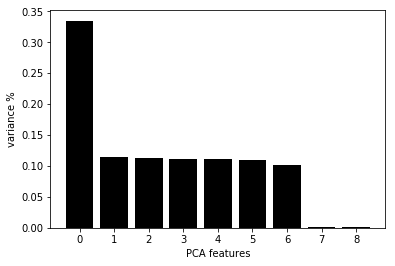

In [19]:
#PCA
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(X_train_numeric)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [20]:
# Fit on training set only.
pca = PCA(n_components=7).fit(X_train_numeric)

# Apply transform to both the training set and the test set.
pca_train = pca.transform(X_train_numeric)
pca_test = pca.transform(X_test_numeric)

# Save components to a DataFrame
PCA_components_train = pd.DataFrame(pca_train)
PCA_components_test = pd.DataFrame(pca_test)

# Merge principal components with main dataframe
X_train = pd.concat([X_train, PCA_components_train], axis = 1)
X_test = pd.concat([X_test, PCA_components_test], axis = 1)

X_train.drop(numeric_features, axis = 1, inplace = True)
X_test.drop(numeric_features, axis = 1, inplace = True)

In [21]:
X_train.head()

,UniqueCarrier,Dest,0,1,2,3,4,5,6
0,18,41,-1.490445,-1.311231,-0.441417,-0.569898,0.599264,0.985474,-1.255336
1,17,204,-0.165347,1.729200,-0.223016,-0.665682,1.231656,0.510357,0.282994
2,0,87,-1.531102,0.272664,1.333003,0.476739,2.195193,0.301846,-0.863465
3,17,220,1.014831,0.462528,-0.489077,-1.172350,-1.567586,0.036714,0.726579
4,17,80,-0.416366,1.417720,-0.308677,-1.024915,-1.158486,-0.038385,1.493461


#### Naive Bayes

Default parameters

In [22]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    297445
           1       0.45      0.20      0.27     45276

   micro avg       0.86      0.86      0.86    342721
   macro avg       0.67      0.58      0.60    342721
weighted avg       0.83      0.86      0.84    342721



#### Random Forest

Default parameters

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.99      0.93    297445
           1       0.66      0.14      0.23     45276

   micro avg       0.88      0.88      0.88    342721
   macro avg       0.77      0.56      0.58    342721
weighted avg       0.85      0.88      0.84    342721



Hyperparameter tuning

1  done!
3  done!
5  done!
7  done!
9  done!
11  done!
13  done!
15  done!
20  done!
25  done!


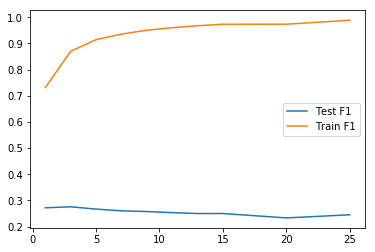

In [24]:
# n_estimators
n_estimators = [1, 3, 5, 7, 9, 11, 13, 15, 20, 25]
test_results = []
train_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1, class_weight = 'balanced')
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    train_pred = model.predict(X_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)

    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results, label='Test F1')
sns.lineplot(x = n_estimators, y = train_results, label='Train F1')

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


14.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


17.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


20.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


23.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


26.0  done!


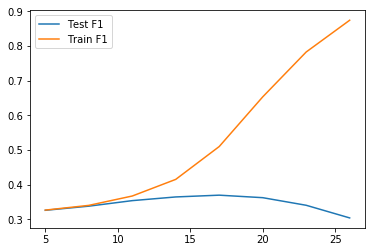

In [25]:
# max_depths
max_depths = np.linspace(5, 26, 8)
test_results = []
train_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth = max_depth, n_jobs = -1, class_weight = 'balanced')
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    train_pred = model.predict(X_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results, label='Test F1')
sns.lineplot(x = max_depths, y = train_results, label='Train F1')

**Final model**

Best parameters:
- n_estimators = 15
- max_depths = 25

In [ ]:
model = RandomForestClassifier(n_estimators = 15, max_depth = 25, n_jobs = -1, class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

### Feature selection

In [ ]:
X_train = X_train_backup.copy()
X_test = X_test_backup.copy()

In [ ]:
# RFE
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced')
rfe = RFE(estimator = model, n_features_to_select = None)
rfe = rfe.fit(X_train, y_train)

#Summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]